### LSTM

In [0]:
# !pip install mido

In [0]:
# !pip install keras
# import keras

In [0]:
# Library to process MIDI files
import tensorflow as tf

In [28]:
tf.__version__

'2.2.0'

In [0]:
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [0]:
import mido
from mido import MidiFile, MidiTrack, Message

In [0]:
# import os

# folder_name = '1-Calming'
# keyword = 'A Presence Felt'
# for fname in os.listdir('midi/'+folder_name):
#     if keyword in fname:
#         print(fname, "has the keyword")

In [0]:
# !unzip midi.zip

In [33]:
# define which song we are using
folder_name = '1-Calming'
song_name = 'ES_A Presence Felt - Gavin Luke'
midi_filename = 'midi/' + folder_name + '/' + song_name + '.mp3.mid'

midi = MidiFile(midi_filename)

cnt = 0
for msg in midi:
  print(msg)
  cnt+=1
  if cnt>100:
    break 

<meta message set_tempo tempo=500000 time=0>
program_change channel=0 program=0 time=0
note_on channel=0 note=76 velocity=14 time=0
note_on channel=0 note=57 velocity=50 time=0.010869565217391304
note_off channel=0 note=76 velocity=64 time=0.2934782608695652
note_on channel=0 note=72 velocity=24 time=0.08695652173913043
note_on channel=0 note=60 velocity=42 time=0.021739130434782608
note_off channel=0 note=57 velocity=64 time=0.021739130434782608
note_off channel=0 note=60 velocity=64 time=0.021739130434782608
note_on channel=0 note=57 velocity=38 time=0.010869565217391304
note_off channel=0 note=57 velocity=64 time=0.10869565217391304
note_on channel=0 note=57 velocity=33 time=0.010869565217391304
note_off channel=0 note=57 velocity=64 time=0.10869565217391304
note_on channel=0 note=57 velocity=29 time=0.010869565217391304
note_on channel=0 note=60 velocity=29 time=0.06521739130434782
note_off channel=0 note=57 velocity=64 time=0.010869565217391304
note_on channel=0 note=64 velocity=3

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [35]:
# save notes for the song as a list

notes = []
for msg in midi:
    if not msg.is_meta and msg.channel == 0 and msg.type == 'note_on':
        data = msg.bytes()
        notes.append(data[1]) # we are just adding the note!
        
print(notes[:15])
print(len(notes))

[76, 57, 72, 60, 57, 57, 57, 60, 64, 57, 57, 57, 57, 60, 60]
3226


In [36]:
## rescale all the notes to the [0,1] interval

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(np.array(notes).reshape(-1,1))
notes = list(scaler.transform(np.array(notes).reshape(-1,1)))

print(notes[:15])
print(len(notes))

[array([0.61016949]), array([0.28813559]), array([0.54237288]), array([0.33898305]), array([0.28813559]), array([0.28813559]), array([0.28813559]), array([0.33898305]), array([0.40677966]), array([0.28813559]), array([0.28813559]), array([0.28813559]), array([0.28813559]), array([0.33898305]), array([0.33898305])]
3226


In [37]:
# predict the next note for the a song sequence

# LSTM layers requires that data must have a certain shape
notes = [list(note) for note in notes]

# subsample data for training and prediction
X = []
y = []
# number of notes in a batch
n_prev = 30
for i in range(len(notes)-n_prev):
    X.append(notes[i:i+n_prev])
    y.append(notes[i+n_prev])
# save a seed to do prediction later
X_test = X[-300:]
y_test = y[-300:]
y_test = [note[0] for note in y_test]
X = X[:-300]
y = y[:-300]

print(len(X))

2896


In [38]:
np.shape(X)

(2896, 30, 1)

In [39]:
np.shape(y)

(2896, 1)

In [40]:
n_prev

30

In [100]:
# Define a model

model = Sequential()


model.add(Conv1D(filters=256, kernel_size=8, strides=1, activation='relu', 
                 input_shape=(n_prev, 1)))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))

model.add(LSTM(128, input_shape=(n_prev, 1), return_sequences=True))
model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(n_prev, 1)))
# model.add(Dropout(0.3))
model.add(LSTM(64, input_shape=(n_prev, 1), return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = Adam(lr=0.001)
model.compile(loss='mse', optimizer=optimizer)

# train model
model.fit(np.array(X), np.array(y), 
          32, 50, verbose=1)#, callbacks=[model_save_callback])

Epoch 1/50
85/85 [==============================] - 2s 22ms/step - loss: 0.0384
Epoch 2/50
85/85 [==============================] - 2s 24ms/step - loss: 0.0377
Epoch 3/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0379
Epoch 4/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0373
Epoch 5/50
85/85 [==============================] - 2s 22ms/step - loss: 0.0372
Epoch 6/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0372
Epoch 7/50
85/85 [==============================] - 2s 22ms/step - loss: 0.0368
Epoch 8/50
85/85 [==============================] - 2s 22ms/step - loss: 0.0368
Epoch 9/50
85/85 [==============================] - 2s 22ms/step - loss: 0.0365
Epoch 10/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0365
Epoch 11/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0364
Epoch 12/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0366
Epoch 13/50
85/85 [==================

In [0]:
# predict notes from test sequence

def get_pred(model, X_test, y_test):
    pred_test = model.predict(np.array(X_test))
    pred = np.squeeze(pred_test)
    pred_test = [note[0] for note in pred_test]
    pred = np.squeeze(scaler.inverse_transform(pred.reshape(-1,1)))
    pred_note = [int(i) for i in pred]
    
    mse = mean_squared_error(pred_test, y_test)

    return pred_test, pred_note, mse

pred_test, pred_note, mse = get_pred(model, X_test, y_test)
# pred_test, pred_note, mse = get_pred(model, X, y)

In [102]:
# mean squared error for prediction
print(mse)

0.03341952995392885


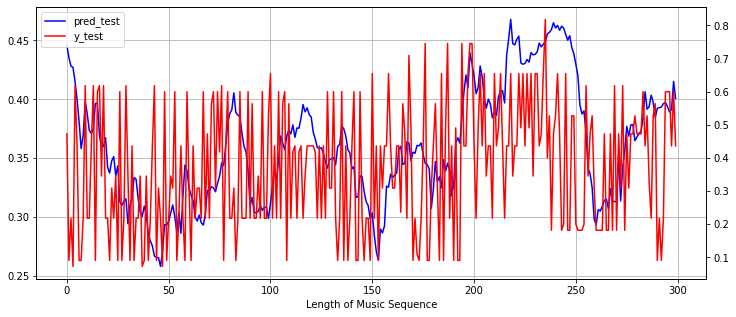

In [103]:
# plot the sequences generated

def plot_pred_seq(pred_test, y_test):

    df = pd.DataFrame({'pred_test': pred_test, 'y_test': y_test})

    plt.figure(figsize=(12,5))
    plt.xlabel('Length of Music Sequence')

    ax1 = df.pred_test.plot(color='blue', grid=True, label='pred_test')
    ax2 = df.y_test.plot(color='red', grid=True, secondary_y=True, label='y_test')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()


    plt.legend(h1+h2, l1+l2, loc=2)
    plt.show()
    
plot_pred_seq(pred_test, y_test)
# plot_pred_seq(pred_test, [note[0] for note in y])

In [0]:
# !unzip midi_generated.zip

In [0]:
# generate midi files
mid = MidiFile()
track = MidiTrack()
t = 0
for note in pred_note:
    # 147 means note_on
    # 67 is velocity
    note = np.asarray([147, note, 127]) 
    bytes = note.astype(int)
    msg = Message.from_bytes(bytes[0:3])
    t += 1
    msg.time = t
    track.append(msg)
    
mid.tracks.append(track)

mid.save('midi_generated/' + folder_name + '/' + song_name + '_gen.mid')

In [49]:
midi_filename

'midi/1-Calming/ES_A Presence Felt - Gavin Luke.mp3.mid'

In [0]:
## bidirectional lstm

In [0]:
n_prev = 500

In [80]:
np.shape(y)

(2896, 1)

In [0]:
# mod_bi = Sequential(name='haha')
# # model_bi.name = 'haha'

# mod_bi.add(Conv1D(filters=128, kernel_size=8, strides=1, activation='relu', 
#                  input_shape=(n_prev, 1)))
# mod_bi.add(MaxPooling1D(pool_size=4))
# mod_bi.add(Dropout(0.3))


# mod_bi.add(Conv1D(filters=64, kernel_size=8, strides=1, activation='relu', 
#                  input_shape=(n_prev, 1)))
# mod_bi.add(MaxPooling1D(pool_size=4))
# mod_bi.add(Dropout(0.3))

# mod_bi.add(Conv1D(filters=32, kernel_size=8, strides=1, activation='relu', 
#                  input_shape=(n_prev, 1)))
# mod_bi.add(MaxPooling1D(pool_size=4))
# mod_bi.add(Dropout(0.3))

# # mod_bi.add(Bidirectional(LSTM(16, return_sequences=False), input_shape=(n_prev, 1)))
# mod_bi.add(LSTM(16, return_sequences=False, input_shape=(n_prev, 1)))

# mod_bi.add(Dropout(0.3))


# mod_bi.add(Dense(32))
# mod_bi.add(Dense(16))
# mod_bi.add(Dense(1))
# mod_bi.add(Activation('sigmoid'))



# optimizer = Adam(lr=0.001)
# mod_bi.compile(loss='mse', optimizer=optimizer)

# # train model
# mod_bi.fit(np.array(X), np.array(y).reshape(np.shape(y)[0], np.shape(y)[1], 1), 
#           32, 50, verbose=1)#, callbacks=[model_save_callback])

In [0]:
# pred_test, pred_note, mse = get_pred(model_bi, X_test, y_test)
# print('MSE: ', mse)
# plot_pred_seq(pred_test, y_test)

In [0]:
# song_dict.keys()

In [85]:
df_X = pd.read_csv('df_X.csv')
df_X = df_X.fillna(0)

df_X.shape

df_y = pd.read_csv('df_y.csv')
df_y.shape

(50, 1)

In [0]:
n_col = df_X.shape[1]
len_seq = 5000

X_aug = []
y_aug = []

for i_row in range(df_y.shape[0]):
  song_data = df_X.iloc[i_row,:]
  # print(song_data)
  # print(song_data.shape)
  for i_seg in range((n_col//len_seq)):
    col_start = i_seg * len_seq
    # print(col_start)
    col_end = (i_seg + 1) * len_seq
    # print(col_end)
    seg = song_data.iloc[col_start:col_end]
    if sum(seg) == 0.0:
      continue
    else:
      X_aug.append(seg)
      y_aug.append(df_y.iloc[i_row])

# X_aug = pd.DataFrame(X_aug)
np.shape(X_aug)

In [114]:
len(X_aug)

152

ES_Awash - Gavin Luke.mp3.mid
Epoch 1/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0385
Epoch 2/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0378
Epoch 3/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0376
Epoch 4/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0373
Epoch 5/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0371
Epoch 6/50
85/85 [==============================] - 2s 22ms/step - loss: 0.0375
Epoch 7/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0372
Epoch 8/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0367
Epoch 9/50
85/85 [==============================] - 2s 22ms/step - loss: 0.0370
Epoch 10/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0369
Epoch 11/50
85/85 [==============================] - 2s 22ms/step - loss: 0.0365
Epoch 12/50
85/85 [==============================] - 2s 23ms/step - loss: 0.0367
Epoch 1

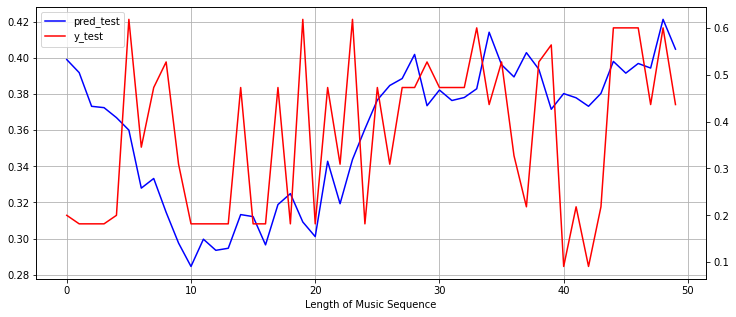

ES_A Whisper In The Dark - Gavin Luke.mp3.mid
Epoch 1/50
147/147 [==============================] - 3s 23ms/step - loss: 0.0382
Epoch 2/50
147/147 [==============================] - 3s 23ms/step - loss: 0.0381
Epoch 3/50
147/147 [==============================] - 3s 22ms/step - loss: 0.0380
Epoch 4/50
147/147 [==============================] - 3s 22ms/step - loss: 0.0379
Epoch 5/50
147/147 [==============================] - 3s 22ms/step - loss: 0.0376
Epoch 6/50
147/147 [==============================] - 3s 23ms/step - loss: 0.0377
Epoch 7/50
147/147 [==============================] - 3s 23ms/step - loss: 0.0374
Epoch 8/50
147/147 [==============================] - 3s 23ms/step - loss: 0.0374
Epoch 9/50
147/147 [==============================] - 3s 23ms/step - loss: 0.0372
Epoch 10/50
147/147 [==============================] - 3s 23ms/step - loss: 0.0374
Epoch 11/50
147/147 [==============================] - 3s 22ms/step - loss: 0.0372
Epoch 12/50
147/147 [=============================

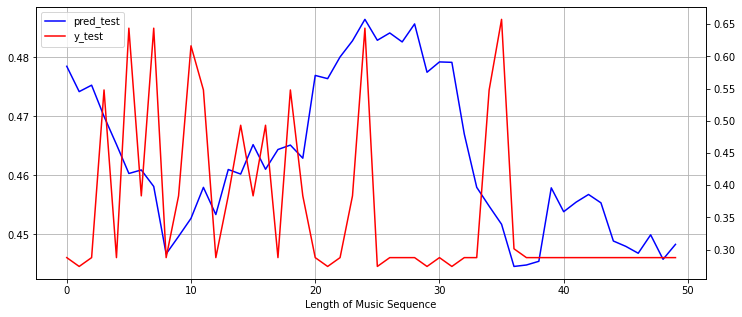

ES_The Crossing - Gavin Luke.mp3.mid
Epoch 1/50
118/118 [==============================] - 2s 21ms/step - loss: 0.0609
Epoch 2/50
118/118 [==============================] - 2s 21ms/step - loss: 0.0606
Epoch 3/50
118/118 [==============================] - 2s 20ms/step - loss: 0.0604
Epoch 4/50
118/118 [==============================] - 2s 20ms/step - loss: 0.0602
Epoch 5/50
118/118 [==============================] - 2s 20ms/step - loss: 0.0605
Epoch 6/50
118/118 [==============================] - 2s 21ms/step - loss: 0.0599
Epoch 7/50
118/118 [==============================] - 2s 20ms/step - loss: 0.0597
Epoch 8/50
118/118 [==============================] - 2s 20ms/step - loss: 0.0598
Epoch 9/50
118/118 [==============================] - 2s 20ms/step - loss: 0.0600
Epoch 10/50
118/118 [==============================] - 2s 20ms/step - loss: 0.0595
Epoch 11/50
118/118 [==============================] - 2s 20ms/step - loss: 0.0596
Epoch 12/50
118/118 [==============================] - 2s 2

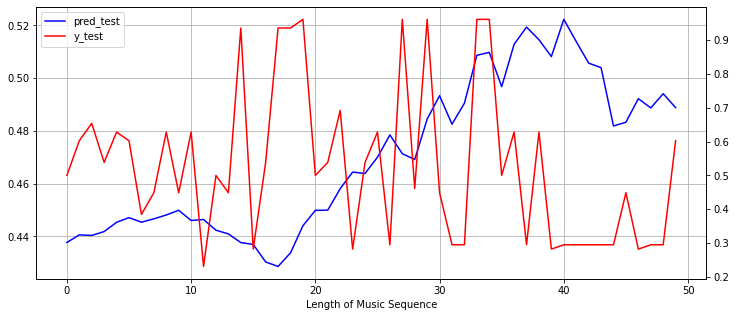

ES_Big Sky - Gavin Luke.mp3.mid
Epoch 1/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0362
Epoch 2/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0355
Epoch 3/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0354
Epoch 4/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0353
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0352
Epoch 6/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0352
Epoch 7/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0352
Epoch 8/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0351
Epoch 9/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0352
Epoch 10/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0349
Epoch 11/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0350
Epoch 12/50
156/156 [==============================] - 4s 22ms/s

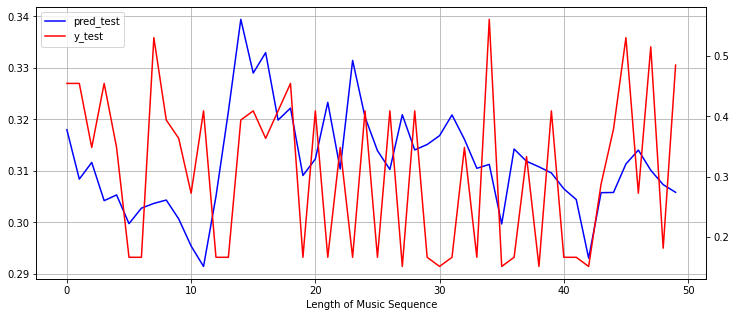

ES_No Good Byes - Amaranth Cove.mp3.mid
Epoch 1/50
10/10 [==============================] - 0s 19ms/step - loss: 0.0296
Epoch 2/50
10/10 [==============================] - 0s 19ms/step - loss: 0.0256
Epoch 3/50
10/10 [==============================] - 0s 19ms/step - loss: 0.0248
Epoch 4/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0247
Epoch 5/50
10/10 [==============================] - 0s 19ms/step - loss: 0.0252
Epoch 6/50
10/10 [==============================] - 0s 19ms/step - loss: 0.0252
Epoch 7/50
10/10 [==============================] - 0s 20ms/step - loss: 0.0245
Epoch 8/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0249
Epoch 9/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0253
Epoch 10/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0250
Epoch 11/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0246
Epoch 12/50
10/10 [==============================] - 0s 19ms/step - loss: 0.02

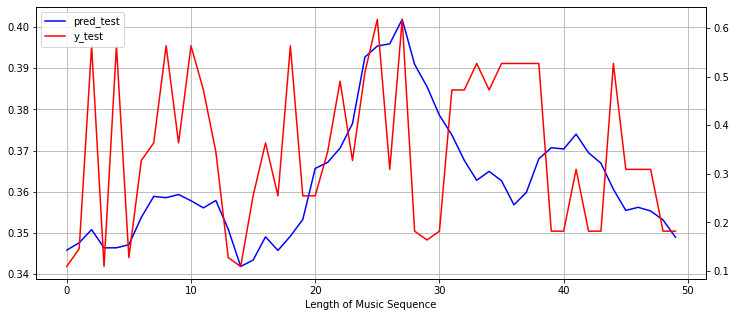

ES_Happy Days Are Long Awaited - River Foxcroft.mp3.mid
Epoch 1/50
100/100 [==============================] - 2s 21ms/step - loss: 0.0452
Epoch 2/50
100/100 [==============================] - 2s 21ms/step - loss: 0.0439
Epoch 3/50
100/100 [==============================] - 2s 21ms/step - loss: 0.0435
Epoch 4/50
100/100 [==============================] - 2s 21ms/step - loss: 0.0434
Epoch 5/50
100/100 [==============================] - 2s 21ms/step - loss: 0.0433
Epoch 6/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0432
Epoch 7/50
100/100 [==============================] - 2s 21ms/step - loss: 0.0434
Epoch 8/50
100/100 [==============================] - 2s 21ms/step - loss: 0.0430
Epoch 9/50
100/100 [==============================] - 2s 21ms/step - loss: 0.0432
Epoch 10/50
100/100 [==============================] - 2s 21ms/step - loss: 0.0430
Epoch 11/50
100/100 [==============================] - 2s 21ms/step - loss: 0.0429
Epoch 12/50
100/100 [===================

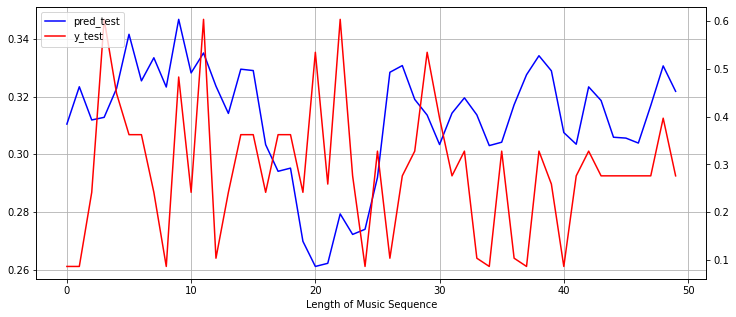

ES_Maybe Another Day - Spectacles Wallet and Watch.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0470
Epoch 2/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0435
Epoch 3/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0429
Epoch 4/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0430
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0423
Epoch 6/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0429
Epoch 7/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0423
Epoch 8/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0424
Epoch 9/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0423
Epoch 10/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0423
Epoch 11/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0423
Epoch 12/50
156/156 [================

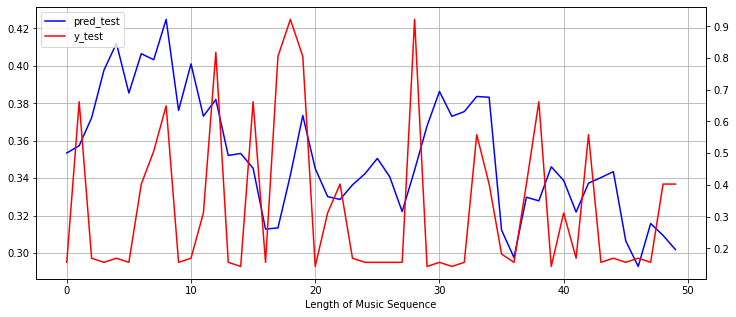

ES_The Human Derivative - Amaranth Cove.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0535
Epoch 2/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0523
Epoch 3/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0518
Epoch 4/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0514
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0514
Epoch 6/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0512
Epoch 7/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0512
Epoch 8/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0511
Epoch 9/50
156/156 [==============================] - 4s 22ms/step - loss: 0.0511
Epoch 10/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0509
Epoch 11/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0510
Epoch 12/50
156/156 [===========================

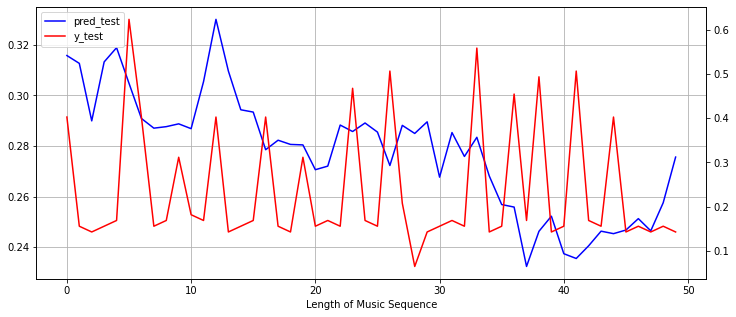

ES_Onthou - Ever So Blue.mp3.mid
Epoch 1/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0607
Epoch 2/50
14/14 [==============================] - 0s 21ms/step - loss: 0.0463
Epoch 3/50
14/14 [==============================] - 0s 21ms/step - loss: 0.0426
Epoch 4/50
14/14 [==============================] - 0s 22ms/step - loss: 0.0422
Epoch 5/50
14/14 [==============================] - 0s 21ms/step - loss: 0.0420
Epoch 6/50
14/14 [==============================] - 0s 21ms/step - loss: 0.0417
Epoch 7/50
14/14 [==============================] - 0s 22ms/step - loss: 0.0400
Epoch 8/50
14/14 [==============================] - 0s 22ms/step - loss: 0.0409
Epoch 9/50
14/14 [==============================] - 0s 22ms/step - loss: 0.0395
Epoch 10/50
14/14 [==============================] - 0s 21ms/step - loss: 0.0388
Epoch 11/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0396
Epoch 12/50
14/14 [==============================] - 0s 22ms/step - loss: 0.0388
Epoc

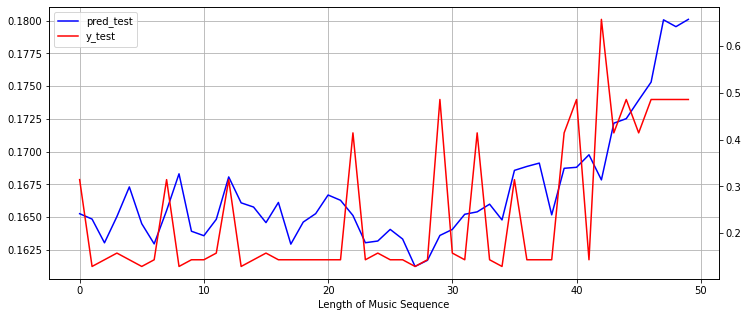

ES_A Presence Felt - Gavin Luke.mp3.mid
Epoch 1/50
142/142 [==============================] - 3s 22ms/step - loss: 0.0321
Epoch 2/50
142/142 [==============================] - 3s 22ms/step - loss: 0.0317
Epoch 3/50
142/142 [==============================] - 3s 23ms/step - loss: 0.0315
Epoch 4/50
142/142 [==============================] - 3s 23ms/step - loss: 0.0313
Epoch 5/50
142/142 [==============================] - 3s 23ms/step - loss: 0.0314
Epoch 6/50
142/142 [==============================] - 3s 23ms/step - loss: 0.0311
Epoch 7/50
142/142 [==============================] - 3s 22ms/step - loss: 0.0313
Epoch 8/50
142/142 [==============================] - 3s 22ms/step - loss: 0.0313
Epoch 9/50
142/142 [==============================] - 3s 22ms/step - loss: 0.0311
Epoch 10/50
142/142 [==============================] - 3s 22ms/step - loss: 0.0312
Epoch 11/50
142/142 [==============================] - 3s 21ms/step - loss: 0.0311
Epoch 12/50
142/142 [==============================] - 3

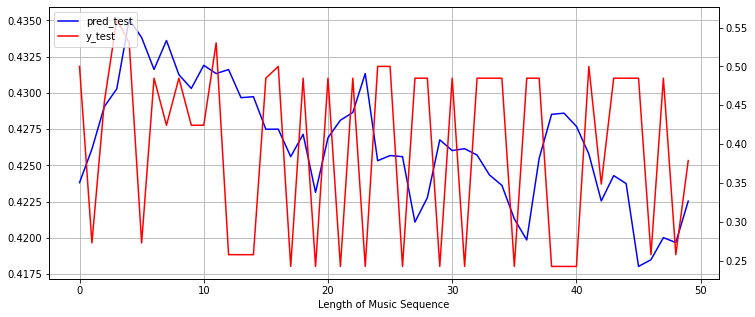

ES_The Sooner The Better - Yesable.mp3.mid
Epoch 1/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0459
Epoch 2/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0441
Epoch 3/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0444
Epoch 4/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0442
Epoch 5/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0443
Epoch 6/50
56/56 [==============================] - 1s 23ms/step - loss: 0.0443
Epoch 7/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0440
Epoch 8/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0440
Epoch 9/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0441
Epoch 10/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0438
Epoch 11/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0441
Epoch 12/50
56/56 [==============================] - 1s 22ms/step - loss: 0

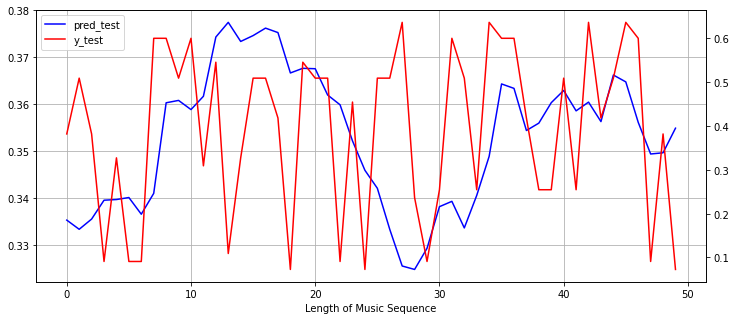

ES_Black Coffee - Mean Dabber.mp3.mid
Epoch 1/50
148/148 [==============================] - 3s 23ms/step - loss: 0.0448
Epoch 2/50
148/148 [==============================] - 3s 22ms/step - loss: 0.0416
Epoch 3/50
148/148 [==============================] - 3s 23ms/step - loss: 0.0401
Epoch 4/50
148/148 [==============================] - 3s 23ms/step - loss: 0.0399
Epoch 5/50
148/148 [==============================] - 3s 23ms/step - loss: 0.0396
Epoch 6/50
148/148 [==============================] - 3s 23ms/step - loss: 0.0398
Epoch 7/50
148/148 [==============================] - 3s 23ms/step - loss: 0.0396
Epoch 8/50
148/148 [==============================] - 3s 23ms/step - loss: 0.0396
Epoch 9/50
148/148 [==============================] - 3s 22ms/step - loss: 0.0398
Epoch 10/50
148/148 [==============================] - 3s 23ms/step - loss: 0.0395
Epoch 11/50
148/148 [==============================] - 3s 22ms/step - loss: 0.0394
Epoch 12/50
148/148 [==============================] - 3s 

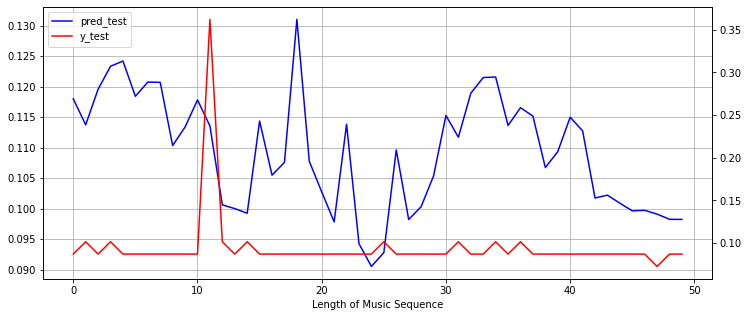

ES_Shiatsu - Catiso.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0476
Epoch 2/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0469
Epoch 3/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0467
Epoch 4/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0464
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0463
Epoch 6/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0464
Epoch 7/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0462
Epoch 8/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0460
Epoch 9/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0461
Epoch 10/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0459
Epoch 11/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0458
Epoch 12/50
156/156 [==============================] - 3s 22ms/step 

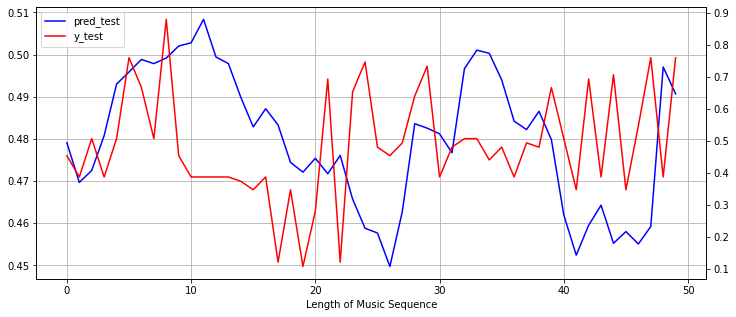

ES_Unleash My Halo - Sum Wave.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0483
Epoch 2/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0476
Epoch 3/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0470
Epoch 4/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0468
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0469
Epoch 6/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0465
Epoch 7/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0466
Epoch 8/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0463
Epoch 9/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0462
Epoch 10/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0463
Epoch 11/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0460
Epoch 12/50
156/156 [==============================] - 3s 

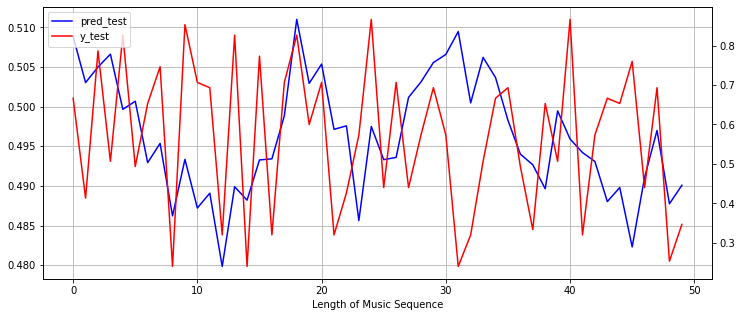

ES_Kermode - Tigerblood Jewel.mp3.mid
Epoch 1/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0638
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0581
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0533
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0502
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0511
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0509
Epoch 7/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0493
Epoch 8/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0516
Epoch 9/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0506
Epoch 10/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0497
Epoch 11/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0506
Epoch 12/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0514
Epoch 13/50
6/6 [======

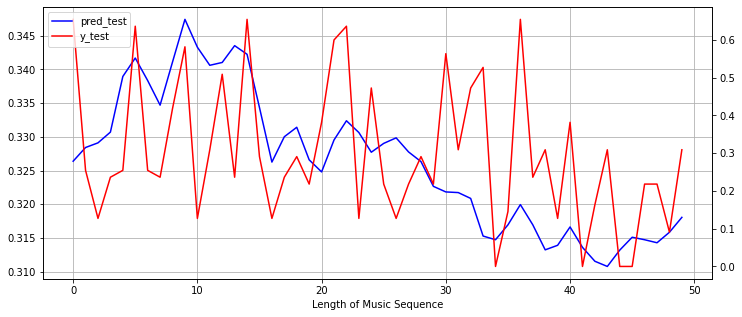

ES_Kraken - Catiso.mp3.mid
Epoch 1/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0856
Epoch 2/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0848
Epoch 3/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0828
Epoch 4/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0799
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0774
Epoch 6/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0755
Epoch 7/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0745
Epoch 8/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0738
Epoch 9/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0725
Epoch 10/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0725
Epoch 11/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0707
Epoch 12/50
156/156 [==============================] - 3s 21ms/step -

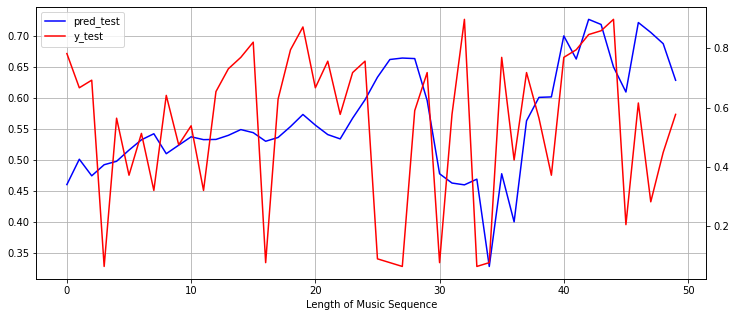

ES_Take Cover - Josh Gram.mp3.mid
Epoch 1/50
156/156 [==============================] - 4s 22ms/step - loss: 0.0684
Epoch 2/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0682
Epoch 3/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0674
Epoch 4/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0665
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0658
Epoch 6/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0655
Epoch 7/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0648
Epoch 8/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0650
Epoch 9/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0645
Epoch 10/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0644
Epoch 11/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0645
Epoch 12/50
156/156 [==============================] - 3s 22ms

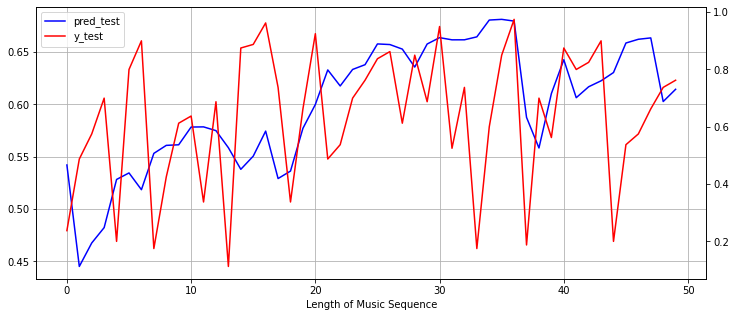

ES_Body Work - Mean Dabber.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0798
Epoch 2/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0794
Epoch 3/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0791
Epoch 4/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0789
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0787
Epoch 6/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0789
Epoch 7/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0788
Epoch 8/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0782
Epoch 9/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0780
Epoch 10/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0775
Epoch 11/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0774
Epoch 12/50
156/156 [==============================] - 3s 22m

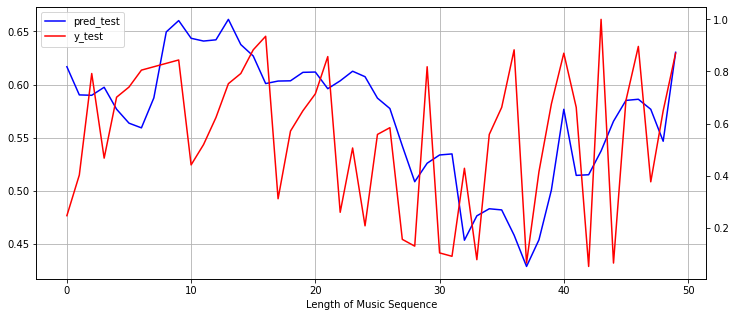

ES_No Sugar Coated Love - Tape Machines.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0767
Epoch 2/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0759
Epoch 3/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0760
Epoch 4/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0759
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0761
Epoch 6/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0758
Epoch 7/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0757
Epoch 8/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0758
Epoch 9/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0757
Epoch 10/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0752
Epoch 11/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0751
Epoch 12/50
156/156 [===========================

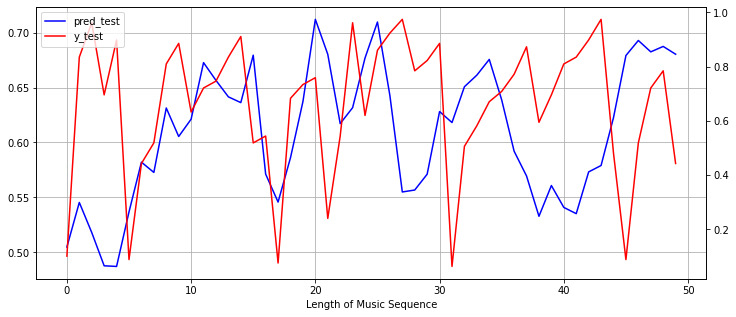

ES_Run Till Dawn - Killrude.mp3.mid
Epoch 1/50
148/148 [==============================] - 3s 22ms/step - loss: 0.0839
Epoch 2/50
148/148 [==============================] - 3s 21ms/step - loss: 0.0836
Epoch 3/50
148/148 [==============================] - 3s 22ms/step - loss: 0.0833
Epoch 4/50
148/148 [==============================] - 3s 22ms/step - loss: 0.0828
Epoch 5/50
148/148 [==============================] - 3s 22ms/step - loss: 0.0819
Epoch 6/50
148/148 [==============================] - 3s 22ms/step - loss: 0.0806
Epoch 7/50
148/148 [==============================] - 3s 23ms/step - loss: 0.0800
Epoch 8/50
148/148 [==============================] - 3s 21ms/step - loss: 0.0804
Epoch 9/50
148/148 [==============================] - 3s 22ms/step - loss: 0.0796
Epoch 10/50
148/148 [==============================] - 3s 22ms/step - loss: 0.0796
Epoch 11/50
148/148 [==============================] - 3s 22ms/step - loss: 0.0790
Epoch 12/50
148/148 [==============================] - 3s 22

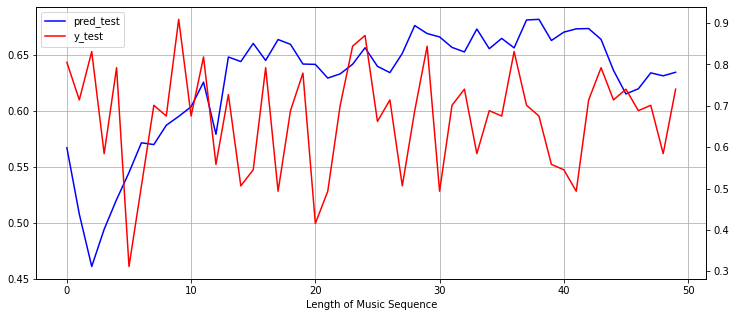

ES_Lethal Secrets - Christoffer Moe Ditlevsen.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0663
Epoch 2/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0629
Epoch 3/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0618
Epoch 4/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0601
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0605
Epoch 6/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0594
Epoch 7/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0594
Epoch 8/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0592
Epoch 9/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0588
Epoch 10/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0590
Epoch 11/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0586
Epoch 12/50
156/156 [=====================

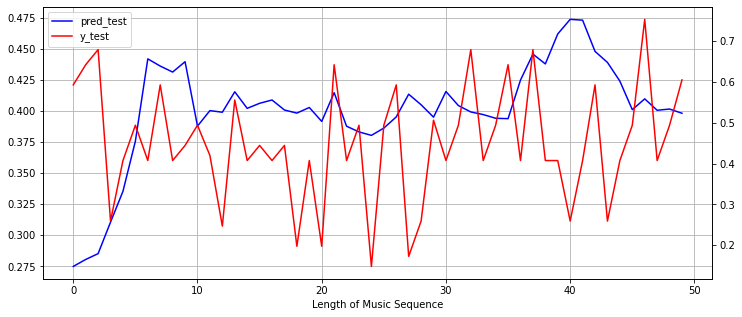

ES_Stasis - Gregory David.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0727
Epoch 2/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0722
Epoch 3/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0718
Epoch 4/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0703
Epoch 5/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0685
Epoch 6/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0673
Epoch 7/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0667
Epoch 8/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0656
Epoch 9/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0661
Epoch 10/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0655
Epoch 11/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0656
Epoch 12/50
156/156 [==============================] - 4s 23ms

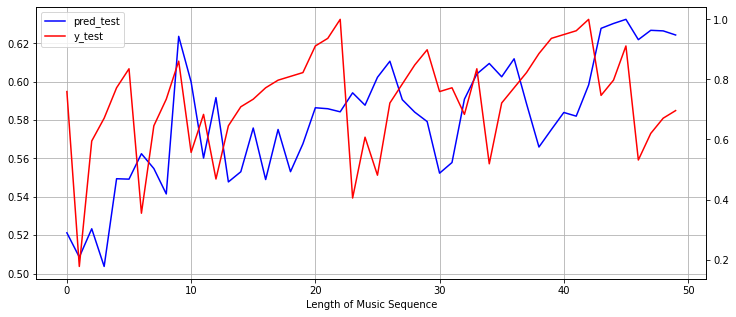

ES_Cloak - Christoffer Moe Ditlevsen.mp3.mid
Epoch 1/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0590
Epoch 2/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0543
Epoch 3/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0528
Epoch 4/50
156/156 [==============================] - 4s 23ms/step - loss: 0.0523
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0513
Epoch 6/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0511
Epoch 7/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0510
Epoch 8/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0507
Epoch 9/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0506
Epoch 10/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0504
Epoch 11/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0502
Epoch 12/50
156/156 [==============================

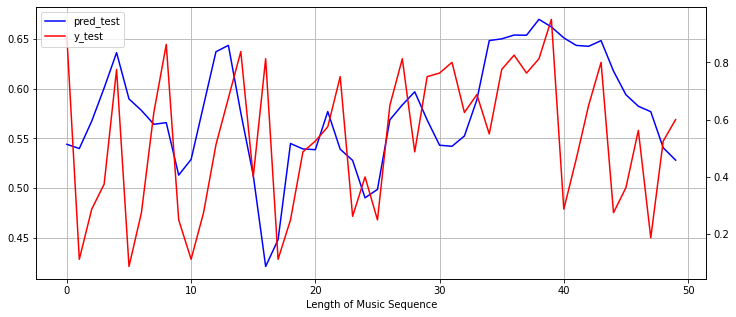

ES_Ginger Root - Sarah the Illstrumentalist.mp3.mid
Epoch 1/50
44/44 [==============================] - 1s 21ms/step - loss: 0.0673
Epoch 2/50
44/44 [==============================] - 1s 21ms/step - loss: 0.0671
Epoch 3/50
44/44 [==============================] - 1s 21ms/step - loss: 0.0671
Epoch 4/50
44/44 [==============================] - 1s 22ms/step - loss: 0.0665
Epoch 5/50
44/44 [==============================] - 1s 23ms/step - loss: 0.0665
Epoch 6/50
44/44 [==============================] - 1s 22ms/step - loss: 0.0664
Epoch 7/50
44/44 [==============================] - 1s 21ms/step - loss: 0.0663
Epoch 8/50
44/44 [==============================] - 1s 21ms/step - loss: 0.0664
Epoch 9/50
44/44 [==============================] - 1s 21ms/step - loss: 0.0664
Epoch 10/50
44/44 [==============================] - 1s 21ms/step - loss: 0.0665
Epoch 11/50
44/44 [==============================] - 1s 21ms/step - loss: 0.0664
Epoch 12/50
44/44 [==============================] - 1s 21ms/step 

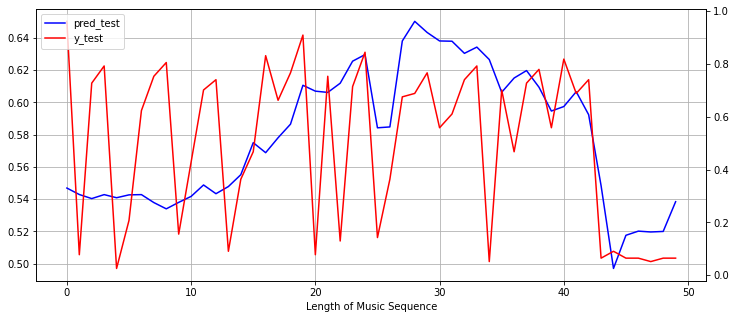

ES_The Unveiling - Christoffer Moe Ditlevsen.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0740
Epoch 2/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0730
Epoch 3/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0717
Epoch 4/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0709
Epoch 5/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0702
Epoch 6/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0702
Epoch 7/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0696
Epoch 8/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0691
Epoch 9/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0687
Epoch 10/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0681
Epoch 11/50
156/156 [==============================] - 3s 22ms/step - loss: 0.0678
Epoch 12/50
156/156 [======================

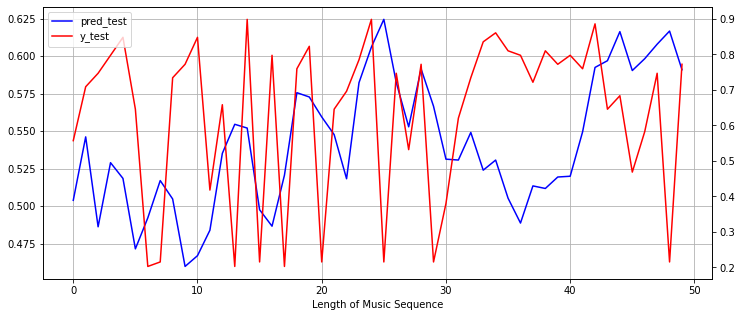

ES_The Mole - Christoffer Moe Ditlevsen.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0744
Epoch 2/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0737
Epoch 3/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0718
Epoch 4/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0717
Epoch 5/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0706
Epoch 6/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0702
Epoch 7/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0696
Epoch 8/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0696
Epoch 9/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0692
Epoch 10/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0693
Epoch 11/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0691
Epoch 12/50
156/156 [===========================

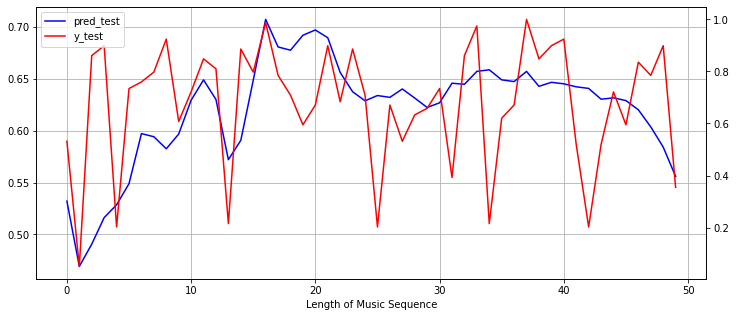

ES_Remote - Damma Beatz.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0727
Epoch 2/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0721
Epoch 3/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0717
Epoch 4/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0711
Epoch 5/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0705
Epoch 6/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0700
Epoch 7/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0701
Epoch 8/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0698
Epoch 9/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0699
Epoch 10/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0701
Epoch 11/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0696
Epoch 12/50
156/156 [==============================] - 3s 20ms/s

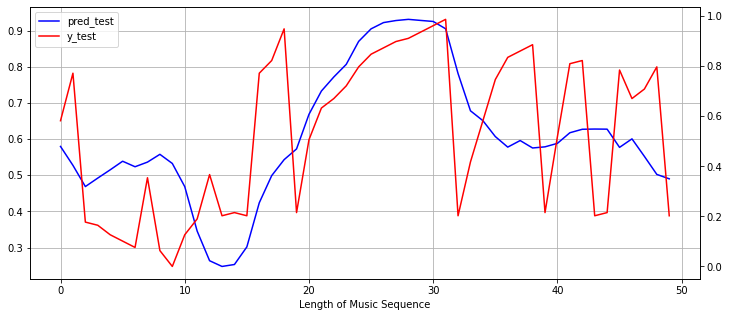

ES_Fiona - Power Druid.mp3.mid
Epoch 1/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0957
Epoch 2/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0939
Epoch 3/50
38/38 [==============================] - 1s 19ms/step - loss: 0.0934
Epoch 4/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0925
Epoch 5/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0924
Epoch 6/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0904
Epoch 7/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0908
Epoch 8/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0886
Epoch 9/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0875
Epoch 10/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0851
Epoch 11/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0856
Epoch 12/50
38/38 [==============================] - 1s 21ms/step - loss: 0.0869
Epoch 

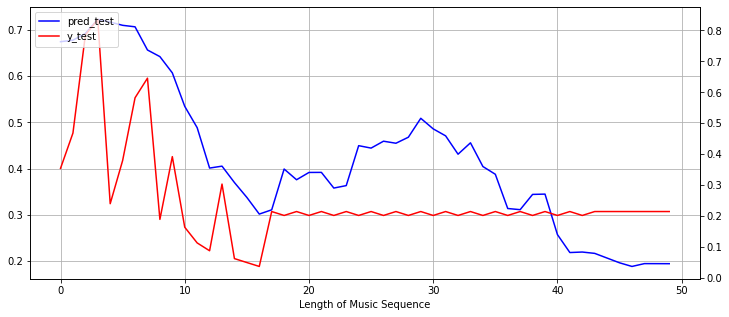

ES_Fighter Jet - Damma Beatz.mp3.mid
Epoch 1/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0533
Epoch 2/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0527
Epoch 3/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0526
Epoch 4/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0522
Epoch 5/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0524
Epoch 6/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0524
Epoch 7/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0523
Epoch 8/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0522
Epoch 9/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0523
Epoch 10/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0522
Epoch 11/50
 10/156 [>.............................] - ETA: 2s - loss: 0.0521Buffered data was truncated after reaching the output size limit.

In [116]:
### Everything ###

import os
song_dict = {}
music_list = pd.read_csv('music_list.csv')
for folder_name in music_list.columns:
#     print(folder_name, '\n')
    song_dict[folder_name] = []
    for fname in os.listdir('midi/'+folder_name):
#         print('fname: ', fname)
        song_dict[folder_name].append(fname)

# print(song_dict['1-Calming'])

# for i_notes in range(df_X.shape[0]):
    
#     folder_name = df_y.iloc[i_notes,:].tolist()[0]
#     song_name = song_dict



i_notes = 0
for folder_name in song_dict.keys():
    for song_name in song_dict[folder_name]:
        if song_name != '.DS_Store':
            print(song_name)
            
            # notes = df_X.iloc[i_notes, :].tolist()
            notes = X_aug[i_notes]
            notes = [note for note in notes if note !=0]

            scaler = MinMaxScaler(feature_range=(0,1))
            scaler.fit(np.array(notes).reshape(-1,1))
            notes = list(scaler.transform(np.array(notes).reshape(-1,1)))
            
            
            
#             print(notes)
        #     print(notes)
            # predict the next note for the a song sequence

            # LSTM layers requires that data must have a certain shape
            notes = [list(note) for note in notes]

            # subsample data for training and prediction
            X = []
            y = []
            # number of notes in a batch
            n_prev = 30
            for i in range(len(notes)-n_prev):
                X.append(notes[i:i+n_prev])
                y.append(notes[i+n_prev])
            # save a seed to do prediction later
            X_test = X[-50:]
            y_test = y[-50:]
            y_test = [note[0] for note in y_test]
            X_train = X[:-50]
            y_train = y[:-50]

            ########
            # Define a model
            ########
            # Define a model

            model = Sequential()

            model.add(Conv1D(filters=256, kernel_size=8, strides=1, activation='relu', 
                            input_shape=(n_prev, 1)))
            model.add(MaxPooling1D(pool_size=4))
            model.add(Dropout(0.3))

            model.add(LSTM(128, input_shape=(n_prev, 1), return_sequences=True))
            model.add(Dropout(0.3))
            # model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(n_prev, 1)))
            # model.add(Dropout(0.3))
            model.add(LSTM(64, input_shape=(n_prev, 1), return_sequences=False))
            model.add(Dropout(0.3))

            model.add(Dense(32))
            model.add(Dense(16))
            model.add(Dense(1))
            model.add(Activation('sigmoid'))



            optimizer = Adam(lr=0.001)
            model.compile(loss='mse', optimizer=optimizer)

            # train model
            model.fit(np.array(X), np.array(y), 
                      32, 50, verbose=1)#, callbacks=[model_save_callback])
            pred_test, pred_note, mse = get_pred(model, X_test, y_test)

            plot_pred_seq(pred_test, y_test)

            # generate midi files
            mid = MidiFile()
            track = MidiTrack()
            t = 0
            for note in pred_note:
                # 147 means note_on
                # 67 is velocity
                note = np.asarray([147, note, 127]) 
                bytes = note.astype(int)
                msg = Message.from_bytes(bytes[0:3])
                t += 1
                msg.time = t
                track.append(msg)

            mid.tracks.append(track)

            mid.save('midi_generated/' + folder_name + '/' + song_name + '_gen.mid')

            i_notes += 1

### MusicVAE